# Connect to Trader Workstation 
** from Interactive Brokers (testing use port 7497 for paper trading account.) **

In [181]:
# common imports
import numpy as np
import os

from ib_insync import *
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=3)

<IB connected to 127.0.0.1:7497 clientId=3>

Test for connection

In [182]:
ib.isConnected()

True

Select the Stock we wish to model.

In [183]:

contract = Stock('TSLA', 'SMART', 'USD')
# shows date of first available historical data (how far back we can model).
ib.reqHeadTimeStamp(contract, whatToShow='TRADES', useRTH=True)

datetime.datetime(2010, 6, 29, 8, 0)

In [39]:
# TRADES HISTORICAL_VOLATILITY OPTION_IMPLIED_VOLATILITY

In [184]:
trade_data = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='90 D',
        barSizeSetting='1 min',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

 Option implied volitiilty data 

In [185]:
option_implied_vol = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='90 D',
        barSizeSetting='1 min',
        whatToShow='OPTION_IMPLIED_VOLATILITY',
        useRTH=True,
        formatDate=1)

In [186]:
option_implied_vol[0]
# trade_data[0]

BarData(date=datetime.datetime(2018, 4, 10, 6, 30), open=0.62367767, high=0.62367767, low=0.60111999, close=0.60111999, average=0.62367767)

Helper function to ready data

In [187]:
def data_prep(trade_data, option_implied_vol):
    # convert into dataframes 
    df_trades = util.df(trade_data)
    df_optImpVol = util.df(option_implied_vol)
    # remove empty colums (volume, barcount) and rename columns so they dont conflict with Trades
    df_optImpVol.drop(columns=['volume', 'barCount'], inplace=True)
    # Rename cols
    df_optImpVol.rename(index=str, columns={"open": "volOpen", "high":"volHigh", "low":"volLow", "close":"volClose", "average":"volAverage"})
    # Merge datasets
    df_merged = df_trades.merge(df_optImpVol, left_on='date', right_on='date', how='outer')
    #  add new columns and normalize data. 
    #  ROC_min = close_x - open_x / open_x * 100    # Rate of change per minute
    df_merged['ROC_min'] = ( df_merged['close_x'] - df_merged['open_x'] ) / ( df_merged['open_x']  ) 
    #  perMinVol = high_x - low_x / low_x * 100     # intra minute spread volitity
    df_merged['perMinVol'] = ( df_merged['high_x'] - df_merged['low_x'] ) / df_merged['low_x'] 
    # adding 7day rolling mean for price 
    df_merged['rollMean_7day'] = df_merged['close_x'].rolling(2940).mean()
    # drop unwanted columns: open_x, high_x, low_x, average_x, open_y, hight_y, low_y, average_y 
    df_merged.drop(columns=['date','open_x', 'high_x', 'low_x', 'average_x', 'open_y', 'high_y', 'low_y', 'average_y'], inplace=True)
#     # Rename cols
#     df_merged.rename(index=str, columns={"close_x":"price_close", "close_y":"avgMinVol"})
#     df_merged.head(3)

    return df_merged



In [214]:
df = data_prep(trade_data, option_implied_vol)
print(df.shape)
print(df.head(3))
# remove the NaN's from rollMean_7day
df = df[2950 : ]
print(df.shape)
print(df.head(3))


(34920, 7)
   close_x  volume  barCount   close_y   ROC_min  perMinVol  rollMean_7day
0   297.58    1756       538  0.601120 -0.004050   0.007073            NaN
1   294.97     930       484  0.601120 -0.007737   0.008515            NaN
2   294.09     854       483  0.614582 -0.002747   0.006402            NaN
(31970, 7)
      close_x  volume  barCount   close_y   ROC_min  perMinVol  rollMean_7day
2950   295.83     130        67  0.545797 -0.001957   0.002096     296.880895
2951   295.38     118        83  0.545797 -0.001454   0.002712     296.880320
2952   295.63     117        64  0.547718  0.000440   0.002237     296.879350


In [311]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
# dataset = read_csv('/Users/lorinfields/Downloads/pollution.csv', header=0, index_col=0)
dataset = df

values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# # ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print('scaled', scaled[1])
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print('This is reframed.head ', reframed.head())
print('reframed shape', reframed.shape)

scaled [0.19425869 0.0108019  0.01710282 0.6464882  0.4806246  0.06093334
 0.22548771]
This is reframed.head     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.198270   0.011900   0.013806   0.646488   0.470348   0.047099   
2   0.194259   0.010802   0.017103   0.646488   0.480625   0.060933   
3   0.196487   0.010710   0.013188   0.652902   0.519303   0.050272   
4   0.195953   0.004669   0.005976   0.652902   0.506172   0.017493   
5   0.198359   0.007598   0.009685   0.648449   0.529668   0.028901   

   var7(t-1)   var1(t)  
1   0.225495  0.194259  
2   0.225488  0.196487  
3   0.225475  0.195953  
4   0.225461  0.198359  
5   0.225449  0.198538  
reframed shape (31969, 8)


In [312]:
 
# split into train and test sets
values = reframed.values
n_train_min = 25000
print(values.shape)
print(values[0])
train = values[:n_train_min, :]
test = values[n_train_min:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(31969, 8)
[0.19827032 0.0119004  0.01380589 0.6464882  0.47034776 0.04709882
 0.2254951  0.19425869]
(25000, 1, 7) (25000,) (6969, 1, 7) (6969,)


Train on 25000 samples, validate on 6969 samples
Epoch 1/50
 - 6s - loss: 0.0074 - val_loss: 0.0417
Epoch 2/50
 - 1s - loss: 0.0065 - val_loss: 0.0223
Epoch 3/50
 - 1s - loss: 0.0033 - val_loss: 0.0072
Epoch 4/50
 - 1s - loss: 0.0013 - val_loss: 0.0024
Epoch 5/50
 - 1s - loss: 7.9198e-04 - val_loss: 0.0075
Epoch 6/50
 - 1s - loss: 7.9640e-04 - val_loss: 0.0124
Epoch 7/50
 - 1s - loss: 6.7809e-04 - val_loss: 0.0130
Epoch 8/50
 - 1s - loss: 4.7486e-04 - val_loss: 0.0103
Epoch 9/50
 - 1s - loss: 2.8431e-04 - val_loss: 0.0065
Epoch 10/50
 - 1s - loss: 1.6622e-04 - val_loss: 0.0034
Epoch 11/50
 - 1s - loss: 1.4384e-04 - val_loss: 0.0018
Epoch 12/50
 - 1s - loss: 1.9724e-04 - val_loss: 0.0016
Epoch 13/50
 - 1s - loss: 2.6723e-04 - val_loss: 0.0021
Epoch 14/50
 - 1s - loss: 3.0576e-04 - val_loss: 0.0023
Epoch 15/50
 - 1s - loss: 2.9287e-04 - val_loss: 0.0021
Epoch 16/50
 - 1s - loss: 2.3573e-04 - val_loss: 0.0015
Epoch 17/50
 - 1s - loss: 1.5968e-04 - val_loss: 6.2143e-04
Epoch 18/50
 - 1s - 

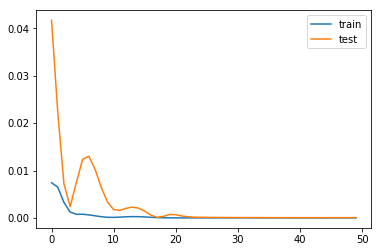

In [313]:
# *** Now we can define and fit our LSTM model.
# We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.
# We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
# The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).
# Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.
# ***
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 


In [314]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_yhat.shape)
print(inv_y.shape)
print(inv_yhat[500])
print(inv_y[500])
runs = len(inv_y)
print(runs)
# if the model predicts the stock is going up it buys a share and sells the following minute.
# if the stock does indeed gain the net is added to total. If it loses the net loss is subtracted 
# from total.
totalGain = 0
totalBuys = 0
for i in range(runs - 1):
    if ((inv_yhat[i + 1] - inv_y[i]) > .3 ):
        totalGain += inv_y[i + 1] - inv_y[i]
        totalBuys += 1
#         print('gain= ', inv_yhat[i + 1] - inv_y[i])
#         print('% gain= ', ((inv_yhat[i + 1] - inv_y[i]) / inv_y[i]))
              
print('totalGain', totalGain)
print('totalBuys', totalBuys)
print('inv_y[])
    
    


Test RMSE: 1.053
(6969,)
(6969,)
296.633
296.9
6969
totalGain 43.700164794921875
totalBuys 1716


In [310]:
ib.disconnect()